In [ ]:
# 前两个留300个 segment成5秒 剩余太少不要 留前六个（合并train-test之后

# Output出三种格式
# 格式要求
# 1. VGG 1秒左右
# 2. 5秒
# Process完问哪几个audio feature适合我们的task  4个左右的feature

In [ ]:
# Packages
from datasets import load_dataset, Audio, concatenate_datasets
from datasets import DatasetDict
import numpy as np
import librosa
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Data Loading
ds = load_dataset("DTU54DL/common-accent")
train_ds = ds["train"].cast_column("audio", Audio(sampling_rate=16_000))
test_ds  = ds["test"].cast_column("audio", Audio(sampling_rate=16_000))

full_ds = concatenate_datasets([train_ds, test_ds])
full_ds

Dataset({
    features: ['audio', 'sentence', 'accent'],
    num_rows: 10451
})

In [ ]:
# Distribution of combined data
accent_counts = Counter(full_ds["accent"])

df_accent = (
    pd.DataFrame.from_dict(accent_counts, orient="index", columns=["count"])
      .sort_values("count", ascending=False)
)

# Top 6
print("\nAccent Distribution (top 6):")
print(df_accent.head(6))


Accent Distribution (top 6):
                                                    count
India and South Asia (India, Pakistan, Sri Lanka)    6077
German English,Non native speaker                    3024
Southern African (South Africa, Zimbabwe, Namibia)    332
Filipino                                              302
Hong Kong English                                     219
Singaporean English                                   214


In [ ]:
# keep only top 6
top6_accents = [acc for acc, _ in accent_counts.most_common(6)]
filtered_ds = full_ds.filter(lambda example: example["accent"] in top6_accents)

Filter:   0%|          | 0/10451 [00:00<?, ? examples/s]

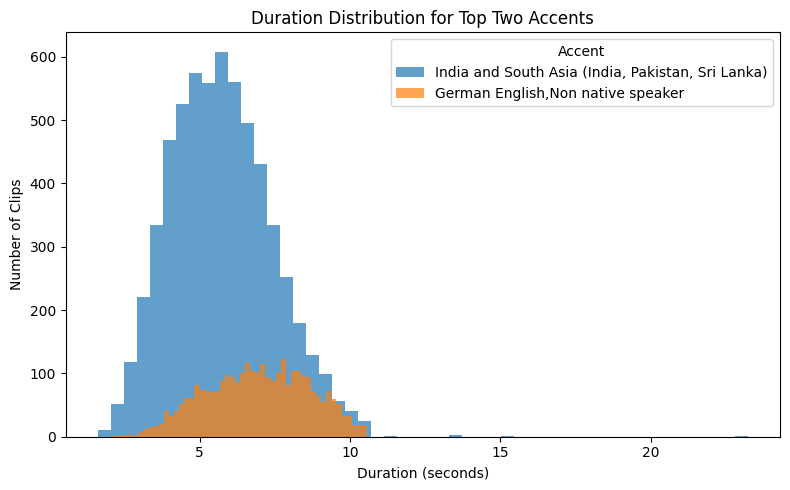

In [ ]:
# top2 Distribution
top2_accents = [acc for acc, _ in accent_counts.most_common(2)]
durations = {acc: [] for acc in top2_accents}
for example in filtered_ds:
    if example["accent"] in top2_accents:
        audio_array = example["audio"]["array"]
        sampling_rate = example["audio"]["sampling_rate"]
        durations[example["accent"]].append(len(audio_array) / sampling_rate)

plt.figure(figsize=(8, 5))
plt.hist(durations[top2_accents[0]], bins=50, alpha=0.7, label=top2_accents[0])
plt.hist(durations[top2_accents[1]], bins=50, alpha=0.7, label=top2_accents[1])
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of Clips")
plt.title("Duration Distribution for Top Two Accents")
plt.legend(title="Accent")
plt.tight_layout()
plt.show()

In [ ]:
# Clips with 3 ≤ duration ≤ 5 seconds in top2
counts_3_5 = {
    acc: sum(3.0 <= d <= 5.0 for d in durations[acc])
    for acc in top2_accents
}

for acc, cnt in counts_3_5.items():
    print(f"{acc}: {cnt} clips between 3 and 5 seconds")

India and South Asia (India, Pakistan, Sri Lanka): 1979 clips between 3 and 5 seconds
German English,Non native speaker: 438 clips between 3 and 5 seconds


In [ ]:
# Randomly sample 400 samples from top2
sampled_datasets = []
for acc in top2_accents:
    # a) filter to just this accent
    acc_ds = filtered_ds.filter(lambda ex: ex["accent"] == acc)
    # b) shuffle and pick 400
    acc_sample = acc_ds.shuffle(seed=42).select(range(400))
    sampled_datasets.append(acc_sample)

Filter:   0%|          | 0/10168 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10168 [00:00<?, ? examples/s]

In [ ]:
sampled_datasets

[Dataset({
     features: ['audio', 'sentence', 'accent'],
     num_rows: 400
 }),
 Dataset({
     features: ['audio', 'sentence', 'accent'],
     num_rows: 400
 })]

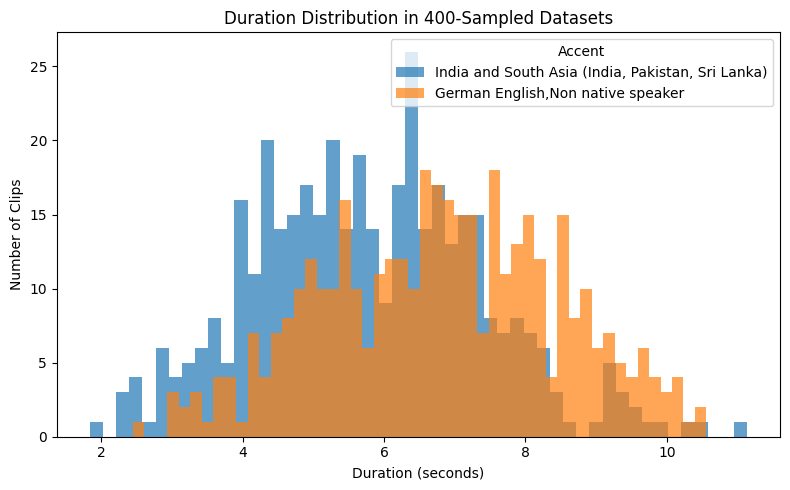

In [ ]:
durations = {}
for ds in sampled_datasets:
    accent = ds[0]['accent']
    durations[accent] = [
        len(ex['audio']['array']) / ex['audio']['sampling_rate']
        for ex in ds
    ]

plt.figure(figsize=(8, 5))
plt.hist(durations[top2_accents[0]], bins=50, alpha=0.7, label=top2_accents[0])
plt.hist(durations[top2_accents[1]], bins=50, alpha=0.7, label=top2_accents[1])
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of Clips")
plt.title("Duration Distribution in 400‑Sampled Datasets")
plt.legend(title="Accent")
plt.tight_layout()
plt.show()

In [ ]:
# Combine to a Final Dataset to use
other_ds = filtered_ds.filter(lambda ex: ex["accent"] not in top2_accents)
final_dataset = concatenate_datasets(sampled_datasets + [other_ds])

In [ ]:
# Distribution of Final Data
accent_counts_final = Counter(final_dataset["accent"])

df_accent_full = (
    pd.DataFrame.from_dict(counts, orient="index", columns=["count"])
      .sort_values("count", ascending=False)
)

print("\nAccent Distribution (top 6):")
print(df_accent_full)


Accent Distribution (top 6):
                                                    count
India and South Asia (India, Pakistan, Sri Lanka)     400
German English,Non native speaker                     400
Southern African (South Africa, Zimbabwe, Namibia)    332
Filipino                                              302
Hong Kong English                                     219
Singaporean English                                   214


In [ ]:
# Simple Cleaning
def clean(data):
    audio = data["audio"]["array"]
    # 1. Mono
    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)
    # 2. Trim silence
    audio, _ = librosa.effects.trim(audio)
    # 3. Normalize peak to 1
    audio = audio / np.max(np.abs(audio))
    return {"speech": audio}

In [ ]:
data = final_dataset.map(clean, remove_columns=["audio"], num_proc=4)

Map (num_proc=4):   0%|          | 0/1867 [00:00<?, ? examples/s]

In [ ]:
# Huggingface
# from huggingface_hub import notebook_login
# notebook_login()

In [ ]:
final_dataset.push_to_hub("ZZZtong/common-accent-YAMNet")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1867 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/19 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ZZZtong/common-accent-YAMNet/commit/0a9a32a7362509e69e4d52baf96d154b7fe57c36', commit_message='Upload dataset', commit_description='', oid='0a9a32a7362509e69e4d52baf96d154b7fe57c36', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/ZZZtong/common-accent-YAMNet', endpoint='https://huggingface.co', repo_type='dataset', repo_id='ZZZtong/common-accent-YAMNet'), pr_revision=None, pr_num=None)

Loading Data:

from datasets import load_dataset

ds = load_dataset("ZZZtong/common-accent-YAMNet")

In [ ]:
# Segment成5秒
from datasets import load_dataset
YAM = load_dataset("ZZZtong/common-accent-YAMNet")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/403 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/77.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1867 [00:00<?, ? examples/s]

In [ ]:
# Train-test Split
from datasets import concatenate_datasets

all_ds = concatenate_datasets([split for split in YAM.values()])

# 80% 20%
split1 = all_ds.train_test_split(test_size=0.2, seed=42)
train_ds = split1["train"]
temp_ds  = split1["test"]

# 10% 10% Test set
split2 = temp_ds.train_test_split(test_size=0.5, seed=42)
val_ds  = split2["train"]
test_ds = split2["test"]

print(f"Train: {len(train_ds)}  ({len(train_ds)/len(all_ds):.2%})")
print(f"Val:   {len(val_ds)}    ({len(val_ds)/len(all_ds):.2%})")
print(f"Test:  {len(test_ds)}   ({len(test_ds)/len(all_ds):.2%})")

Train: 1493  (79.97%)
Val:   187    (10.02%)
Test:  187   (10.02%)


In [ ]:
# Segment audio to 5 seconds clips, if less than 5, padded to 5
train_ds = train_ds.cast_column("audio", Audio(sampling_rate=16_000))

MAX_LEN   = 5 * 16_000
HOP       = MAX_LEN
audio_col = "audio"

def segment_batch(batch):
    seg_audio, seg_sent, seg_acc = [], [], []

    audio_dicts = batch[audio_col]
    sentences   = batch["sentence"]
    accents     = batch["accent"]

    # zip through each example in the batch
    for audio_field, sent, acc in zip(audio_dicts, sentences, accents):
        arr = audio_field.get("array")
        sr  = audio_field.get("sampling_rate")
        if arr is None:
            continue
        for start in range(0, len(arr), HOP):
            chunk = arr[start : start + MAX_LEN]
            if len(chunk) < MAX_LEN:
                chunk = np.pad(chunk, (0, MAX_LEN - len(chunk)), mode="constant")
            seg_audio.append({"array": chunk, "sampling_rate": sr})
            seg_sent.append(sent)
            seg_acc.append(acc)

    return {
        audio_col:     seg_audio,
        "sentence":    seg_sent,
        "accent":      seg_acc,
    }

segmented_ds = train_ds.map(
    segment_batch,
    batched=True,
    batch_size=1,                   # one original clip → many segments
    remove_columns=train_ds.column_names,
)

print(segmented_ds)
print("Total 5 s segments:", len(segmented_ds))


Map:   0%|          | 0/1493 [00:00<?, ? examples/s]

Dataset({
    features: ['audio', 'sentence', 'accent'],
    num_rows: 2538
})
Total 5 s segments: 2538


In [ ]:
# Just checking
MAX_LEN = 5 * 16_000

num_short = sum(
    1
    for ex in train_ds
    if ex["audio"] is not None
    and len(ex["audio"]["array"]) < MAX_LEN
)
print(f"Original clips < 5 s: {num_short}")

Original clips < 5 s: 463


In [ ]:
def segment_dataset(ds):
    return ds.map(
        segment_batch,
        batched=True,
        batch_size=1,
        remove_columns=ds.column_names,
    )

train_chunks = segment_dataset(train_ds)
val_chunks   = segment_dataset(val_ds)
test_chunks  = segment_dataset(test_ds)

print("Train segments:", len(train_chunks))
print("Val   segments:", len(val_chunks))
print("Test  segments:", len(test_chunks))

Map:   0%|          | 0/187 [00:00<?, ? examples/s]

Map:   0%|          | 0/187 [00:00<?, ? examples/s]

Train segments: 2538
Val   segments: 308
Test  segments: 309


In [ ]:
# 1. Combine your splits into a single DatasetDict
dataset_dict = DatasetDict({
    "train":      train_chunks,
    "validation": val_chunks,
    "test":       test_chunks
})


dataset_dict.push_to_hub(
    repo_id="ZZZtong/common-accent-YAMnet",
    private=False
)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/2538 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/26 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ZZZtong/common-accent-YAMnet/commit/0e6562295a889e8975fc1a661d7b2de5e326cd16', commit_message='Upload dataset', commit_description='', oid='0e6562295a889e8975fc1a661d7b2de5e326cd16', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/ZZZtong/common-accent-YAMnet', endpoint='https://huggingface.co', repo_type='dataset', repo_id='ZZZtong/common-accent-YAMnet'), pr_revision=None, pr_num=None)

In [ ]:
import numpy as np
import librosa

def preprocess_for_spectrogram(example):
    x = example["audio"]["array"]
    sr = example["audio"]["sampling_rate"]

    # 1) Resample → 16 kHz
    if sr != 16000:
        x = librosa.resample(x, orig_sr=sr, target_sr=16000)
        sr = 16000

    # 2) Remove DC offset
    x = x - np.mean(x)

    # 3) Peak‑normalize only if non‑zero
    max_val = np.max(np.abs(x))
    if max_val > 1e-9:
        x = x / max_val

    # 4) Pre‑emphasis
    x = np.append(x[0], x[1:] - 0.97 * x[:-1])

    # 5) Force exactly 5 s
    target_len = 5 * sr
    if len(x) < target_len:
        x = np.pad(x, (0, target_len - len(x)), mode="constant")
    else:
        x = x[:target_len]

    # 6) Mel‑spectrogram → log scale
    S = librosa.feature.melspectrogram(
        y=x, sr=sr, n_fft=512, hop_length=160, n_mels=64
    )
    log_S = librosa.power_to_db(S, ref=np.max)

    # 7) Replace any -inf or nan → 0
    log_S = np.nan_to_num(log_S, nan=0.0, neginf=0.0, posinf=0.0).astype(np.float32)

    return {
        "mel_spec": log_S,
        "sentence": example["sentence"],
        "accent":   example["accent"],
    }

# Apply to all three splits
train_processed = train_chunks.map(
    preprocess_for_spectrogram,
    remove_columns=train_chunks.column_names,
    batched=False
)
val_processed = val_chunks.map(
    preprocess_for_spectrogram,
    remove_columns=val_chunks.column_names,
    batched=False
)
test_processed = test_chunks.map(
    preprocess_for_spectrogram,
    remove_columns=test_chunks.column_names,
    batched=False
)

print("Train:", len(train_processed), "examples with mel_spec")
print("Val:  ", len(val_processed))
print("Test: ", len(test_processed))


Map:   0%|          | 0/2538 [00:00<?, ? examples/s]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Train: 2538 examples with mel_spec
Val:   308
Test:  309


<class 'list'>
<class 'list'>
First row, first 10 vals: [-80.0, -80.0, -75.96470642089844, -69.76231384277344, -80.0, -80.0, -80.0, -80.0, -80.0, -80.0]
Shape: (64, 501)
Dtype: float32
Min / Max: -80.0 / 0.0


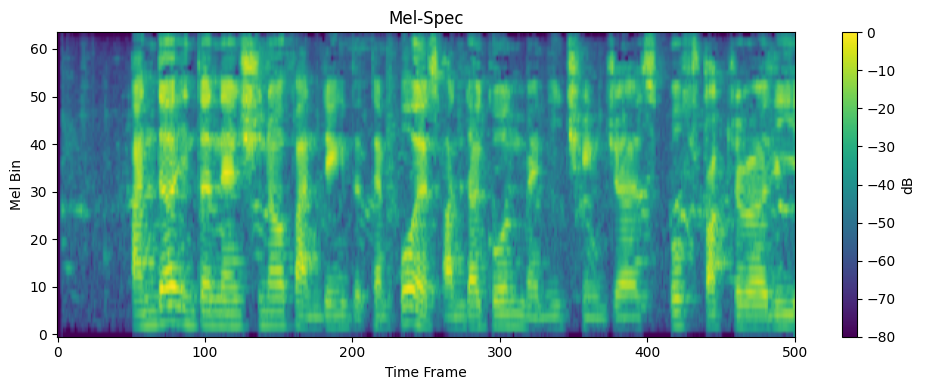

In [ ]:
# Spectrogram Illustration
ex0 = train_processed[9]
raw_mel = ex0["mel_spec"]
print(type(raw_mel))
print(type(raw_mel[0]))
print("First row, first 10 vals:", raw_mel[0][:10])

mel = np.array(raw_mel, dtype=np.float32)
print("Shape:", mel.shape)
print("Dtype:", mel.dtype)
print("Min / Max:", mel.min(), "/", mel.max())

plt.figure(figsize=(10, 4))
plt.imshow(mel, aspect='auto', origin='lower')
plt.colorbar(label='dB')
plt.title("Mel‑Spec")
plt.xlabel("Time Frame")
plt.ylabel("Mel Bin")
plt.tight_layout()
plt.show()

In [ ]:
# VGG
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def prepare_for_vgg(example):
    mel = np.array(example["mel_spec"], dtype=np.float32)

    # 2) to torch.Tensor and add channel dim
    img = torch.from_numpy(mel)            # (H, W)
    img = img.unsqueeze(0)                 # (1, H, W)

    # 3) replicate to 3 channels
    img = img.expand(3, -1, -1)            # (3, H, W)

    # 4) scale pixel values to [0,1]
    mn, mx = img.min(), img.max()
    img = (img - mn) / (mx - mn + 1e-6)

    # 5) resize to 224×224
    img = TF.resize(
        img.unsqueeze(0),
        [224, 224],
        interpolation=TF.InterpolationMode.BILINEAR
    ).squeeze(0)                          # (3, 224, 224)

    # 6) ImageNet‑style normalization
    img = TF.normalize(img, IMAGENET_MEAN, IMAGENET_STD)

    # 7) return as NumPy so datasets stores it directly
    return {"vgg_input": img.numpy()}

train_vgg = train_processed.map(
    prepare_for_vgg,
    batched=False,
    remove_columns=["mel_spec"]
)
val_vgg = val_processed.map(
    prepare_for_vgg,
    batched=False,
    remove_columns=["mel_spec"]
)
test_vgg = test_processed.map(
    prepare_for_vgg,
    batched=False,
    remove_columns=["mel_spec"]
)

print("Train →", len(train_vgg), "examples with vgg_input")
print(" Val  →", len(val_vgg))
print(" Test →", len(test_vgg))


Map:   0%|          | 0/2538 [00:00<?, ? examples/s]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Train → 2538 examples with vgg_input
 Val  → 308
 Test → 309


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# 1. Combine your splits into a single DatasetDict
dataset_dict = DatasetDict({
    "train":      train_vgg,
    "validation": val_vgg,
    "test":       test_vgg
})


dataset_dict.push_to_hub(
    repo_id="ZZZtong/common-accent-vgg-ready",
    private=False
)



Uploading the dataset shards:   0%|          | 0/4 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ZZZtong/common-accent-vgg-ready/commit/d70b3340413c326a264c671710c3a797bf820e09', commit_message='Upload dataset', commit_description='', oid='d70b3340413c326a264c671710c3a797bf820e09', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/ZZZtong/common-accent-vgg-ready', endpoint='https://huggingface.co', repo_type='dataset', repo_id='ZZZtong/common-accent-vgg-ready'), pr_revision=None, pr_num=None)

In [ ]:
# MFCCs
def extract_mfcc(example):
    y = example["audio"]["array"]
    sr = example["audio"]["sampling_rate"]

    # compute MFCCs
    mfcc = librosa.feature.mfcc(
        y=y,
        sr=sr,
        n_mfcc=13,
        n_fft=512,
        hop_length=160
    )

    # compute deltas
    delta1 = librosa.feature.delta(mfcc, order=1)
    delta2 = librosa.feature.delta(mfcc, order=2)

    return {
        "mfcc":    mfcc.astype(np.float32),
        "delta1":  delta1.astype(np.float32),
        "delta2":  delta2.astype(np.float32),
        "sentence": example["sentence"],
        "accent":   example["accent"],
    }

# Map over each split
train_mfcc = train_chunks.map(
    extract_mfcc,
    remove_columns=train_chunks.column_names,
    batched=False
)
val_mfcc = val_chunks.map(
    extract_mfcc,
    remove_columns=val_chunks.column_names,
    batched=False
)
test_mfcc = test_chunks.map(
    extract_mfcc,
    remove_columns=test_chunks.column_names,
    batched=False
)

print("Train w/ MFCC:", len(train_mfcc))
print("Val   w/ MFCC:", len(val_mfcc))
print("Test  w/ MFCC:", len(test_mfcc))

Map:   0%|          | 0/2538 [00:00<?, ? examples/s]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Train w/ MFCC: 2538
Val   w/ MFCC: 308
Test  w/ MFCC: 309


In [ ]:
# Example of MFCCs
raw = train_mfcc[9]["mfcc"]
print("Raw type:", type(raw), "  inner type:", type(raw[0]))

mfcc = np.array(raw, dtype=np.float32)
print("MFCC shape:", mfcc.shape)


Raw type: <class 'list'>   inner type: <class 'list'>
MFCC shape: (13, 501)


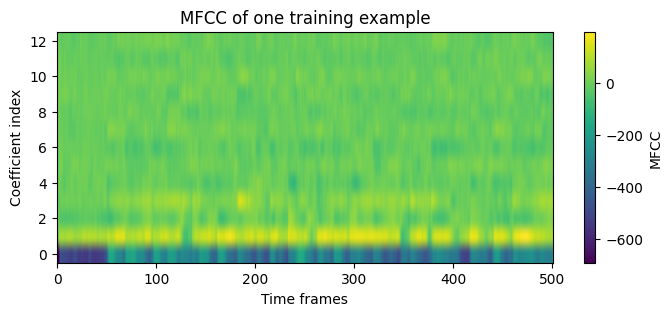

In [ ]:
plt.figure(figsize=(8,3))
plt.imshow(raw, aspect='auto', origin='lower')
plt.colorbar(label='MFCC')
plt.xlabel("Time frames")
plt.ylabel("Coefficient index")
plt.title("MFCC of one training example")
plt.show()

In [ ]:
# Spectral Contrast and Pitch F0

def extract_pitch_contrast(example):
    y = example["audio"]["array"]
    sr = example["audio"]["sampling_rate"]

    # 1) Pitch: use librosa.pyin
    f0, voiced_flag, _ = librosa.pyin(
        y,
        fmin=librosa.note_to_hz("C2"),
        fmax=librosa.note_to_hz("C7"),
        sr=sr, hop_length=160, frame_length=512
    )
    # replace unvoiced (nan) with 0
    f0 = np.nan_to_num(f0, nan=0.0)
    pitch_mean  = np.mean(f0)
    pitch_std   = np.std(f0)
    pitch_range = np.max(f0) - np.min(f0)

    # 2) Spectral Contrast
    spec_con = librosa.feature.spectral_contrast(
        y=y, sr=sr,
        n_fft=512, hop_length=160, n_bands=6
    )  # shape: (n_bands+1, ~500)

    return {
        "pitch_mean":  np.float32(pitch_mean),
        "pitch_std":   np.float32(pitch_std),
        "pitch_range": np.float32(pitch_range),
        "spec_con":    spec_con.astype(np.float32),
        "sentence":    example["sentence"],
        "accent":      example["accent"],
    }


In [ ]:
train_feats = train_chunks.map(
    extract_pitch_contrast,
    batched=False,
    num_proc=4,
    remove_columns=train_chunks.column_names
)

Map (num_proc=4):   0%|          | 0/2538 [00:00<?, ? examples/s]

In [ ]:
train_feats

Dataset({
    features: ['sentence', 'accent', 'pitch_mean', 'pitch_std', 'pitch_range', 'spec_con'],
    num_rows: 2538
})

In [ ]:
val_feats = val_chunks.map(
    extract_pitch_contrast,
    remove_columns=val_chunks.column_names,
    num_proc=4,
    batched=False
)
test_feats = test_chunks.map(
    extract_pitch_contrast,
    remove_columns=test_chunks.column_names,
    num_proc=4,
    batched=False
)

print("Train w/ extra features:", train_feats.column_names)



Map (num_proc=4):   0%|          | 0/308 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/309 [00:00<?, ? examples/s]

Train w/ extra features: ['sentence', 'accent', 'pitch_mean', 'pitch_std', 'pitch_range', 'spec_con']


In [ ]:
# Combine all features

def merge_all_features(base_ds, feat_ds):
    """
    Merge in all columns from feat_ds that aren’t in base_ds.
    Assumes both datasets are the same length and aligned.
    """
    cols_to_add = [c for c in feat_ds.column_names if c not in base_ds.column_names]
    merged = base_ds
    for col in cols_to_add:
        merged = merged.add_column(col, feat_ds[col])
    return merged

# Now merge each split
train_full = merge_all_features(train_combined, train_feats)
val_full   = merge_all_features(val_combined,   val_feats)
test_full  = merge_all_features(test_combined,  test_feats)

# Inspect
print("Train columns:", train_full.column_names)
print("Val   columns:",   val_full.column_names)
print("Test  columns:",  test_full.column_names)

print("Train examples:", len(train_full))
print("Val   examples:", len(val_full))
print("Test  examples:", len(test_full))

# (Optional) package into one dict
all_features_ds = DatasetDict({
    "train":      train_full,
    "validation": val_full,
    "test":       test_full
})


Train columns: ['sentence', 'accent', 'mel_spec', 'mfcc', 'delta1', 'delta2', 'pitch_mean', 'pitch_std', 'pitch_range', 'spec_con']
Val   columns: ['sentence', 'accent', 'mel_spec', 'mfcc', 'delta1', 'delta2', 'pitch_mean', 'pitch_std', 'pitch_range', 'spec_con']
Test  columns: ['sentence', 'accent', 'mel_spec', 'mfcc', 'delta1', 'delta2', 'pitch_mean', 'pitch_std', 'pitch_range', 'spec_con']
Train examples: 2538
Val   examples: 308
Test  examples: 309


In [ ]:
all_features_ds.push_to_hub(
    repo_id="ZZZtong/common-accent-all-features",
    private=False
)

Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ZZZtong/common-accent-all-features/commit/d77f3328a9ddceef6f4a317ee9bf155812ac25a2', commit_message='Upload dataset', commit_description='', oid='d77f3328a9ddceef6f4a317ee9bf155812ac25a2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/ZZZtong/common-accent-all-features', endpoint='https://huggingface.co', repo_type='dataset', repo_id='ZZZtong/common-accent-all-features'), pr_revision=None, pr_num=None)

In [ ]:
# Combine mep-spec and MFCCs
def merge_features(ds_mel, ds_mfcc):
    # ds_mel has columns: ["sentence","accent","mel_spec"]
    # ds_mfcc has columns: ["sentence","accent","mfcc","delta1","delta2"]
    # We’ll keep mel_spec, mfcc, delta1, delta2 and drop the duplicate metadata in ds_mfcc
    return (
        ds_mel
        .add_column("mfcc",   ds_mfcc["mfcc"])
        .add_column("delta1", ds_mfcc["delta1"])
        .add_column("delta2", ds_mfcc["delta2"])
    )


train_combined = merge_features(train_processed, train_mfcc)
val_combined   = merge_features(val_processed,   val_mfcc)
test_combined  = merge_features(test_processed,  test_mfcc)

print(train_combined.column_names)
# → ['sentence','accent','mel_spec','mfcc','delta1','delta2']
print("Train examples:", len(train_combined))
print("Val   examples:", len(val_combined))
print("Test  examples:", len(test_combined))

combined_ds = DatasetDict({
    "train": train_combined,
    "validation": val_combined,
    "test": test_combined
})


['sentence', 'accent', 'mel_spec', 'mfcc', 'delta1', 'delta2']
Train examples: 2538
Val   examples: 308
Test  examples: 309


In [ ]:
combined_ds.push_to_hub(
    repo_id="ZZZtong/common-accent-MelSpec-MFCC",
    private=False
)

Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ZZZtong/common-accent-MelSpec-MFCC/commit/40321d0629cf9f0cb71546740f1e03f4bf1cb379', commit_message='Upload dataset', commit_description='', oid='40321d0629cf9f0cb71546740f1e03f4bf1cb379', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/ZZZtong/common-accent-MelSpec-MFCC', endpoint='https://huggingface.co', repo_type='dataset', repo_id='ZZZtong/common-accent-MelSpec-MFCC'), pr_revision=None, pr_num=None)